In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import pickle
import yaml
import os
import scipy

In [2]:
data = pd.read_parquet('./data/preprocessed.parquet')
data_cfg_path = 'data/dataset_cfg.yaml'

with open(data_cfg_path, 'r') as infile:
    data_cfg = yaml.safe_load(infile)

with open('cfg.yaml', 'r') as infile:
    cfg = yaml.safe_load(infile)

LABEL_COL = data_cfg['data_cols']['label']

preds = pd.read_parquet(f'./synthetic_experts/expert_predictions.parquet').loc[data.index]

metrics = pd.DataFrame(index = preds.columns, columns = ['fpr_disparity', 'Biased Against','TPR','FNR','FPR','TNR','Cost'])
protected_ix  = data.loc[data[data_cfg['data_cols']['protected']] == cfg['protected_class']].index
not_protected_ix  = data.loc[data[data_cfg['data_cols']['protected']] != cfg['protected_class']].index

for expert in preds.columns:
    tn, fp, fn, tp = confusion_matrix(y_pred = preds.loc[protected_ix,expert], y_true = data.loc[protected_ix,LABEL_COL]).ravel()
    protected_fpr = fp/(fp+tn)
    tn, fp, fn, tp = confusion_matrix(y_pred = preds.loc[not_protected_ix,expert], y_true = data.loc[not_protected_ix,LABEL_COL]).ravel()
    not_protected_fpr = fp/(fp+tn)
    tn, fp, fn, tp = confusion_matrix(y_pred = preds[expert], y_true = data[LABEL_COL]).ravel()

    if not_protected_fpr < protected_fpr:
        metrics.loc[expert,'Biased Against'] = 'Female'
    else:
        metrics.loc[expert, 'Biased Against'] = 'Male'
        
    metrics.loc[expert,'Predictive Equality'] = min(not_protected_fpr,protected_fpr)/max(not_protected_fpr,protected_fpr)
    metrics.loc[expert,'TPR'] = tp/(tp+fn)
    metrics.loc[expert,'FPR'] = fp/(fp+tn)
    metrics.loc[expert,'TNR'] = tn/(tn+fp)
    metrics.loc[expert,'FNR'] = fn/(fn+tp)
    metrics.loc[expert,'Cost'] = (fn + fp*data_cfg['lambda'])/(fn+fp+tn+tp)

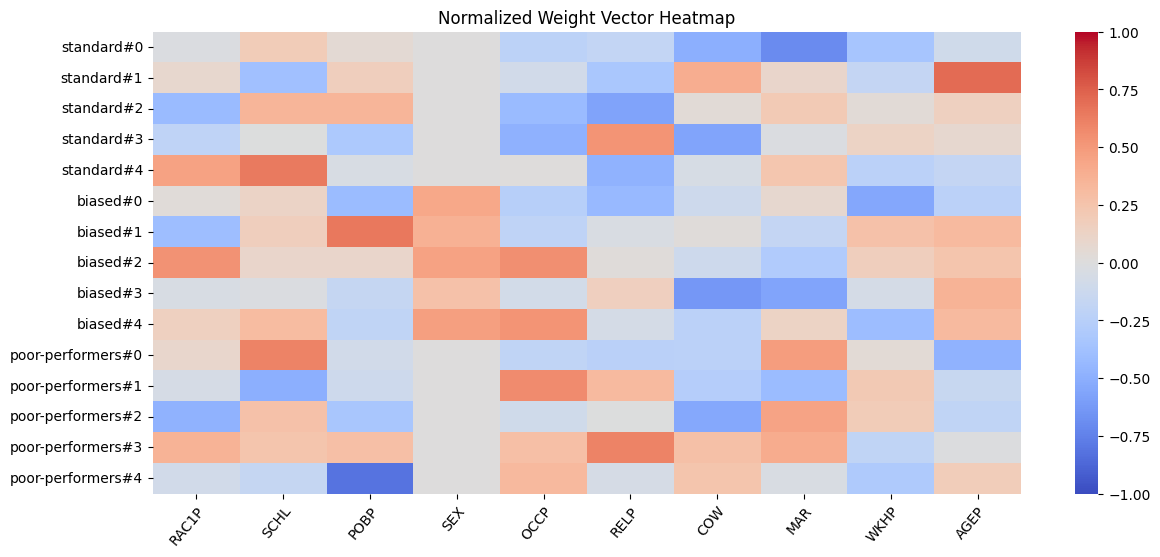

In [3]:
prop = pd.read_parquet(f'./synthetic_experts/expert_parameters.parquet')
w = prop.drop(columns =['fp_beta', 'fn_beta', 'alpha'])
w = w.div(np.sqrt(np.square(w).sum(axis=1)), axis = 0)

f, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(w, robust=True, cmap = 'coolwarm', vmax = 1, vmin = -1, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title("Normalized Weight Vector Heatmap")
plt.xticks(rotation = 50, rotation_mode = 'anchor', ha = 'right')
plt.show()

Text(0.5, 1.0, 'Expert Performance - FPR vs FNR')

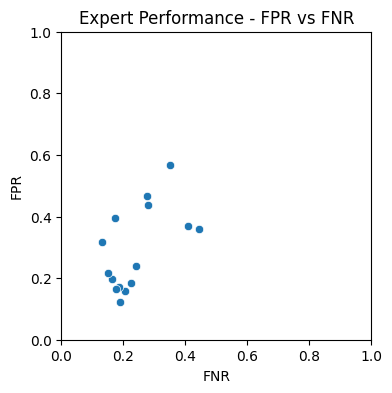

In [4]:
f, ax = plt.subplots(figsize=(4, 4))
tn, fp, fn, tp = confusion_matrix(y_pred = np.ones(len(data[LABEL_COL])), y_true = data[LABEL_COL]).ravel()
l = data_cfg['lambda']
prev = data[LABEL_COL].mean()
cost = (fn+fp*data_cfg['lambda'])/(tp+tn+fp+fn)
slope = -(prev)/(l*(1-prev))
b = cost/(l*(1-prev))
sns.scatterplot(data = metrics.reset_index(), x = 'FNR', y = 'FPR')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Expert Performance - FPR vs FNR')

Text(0.5, 1.0, 'Distribution of Expected Misclassification Cost')

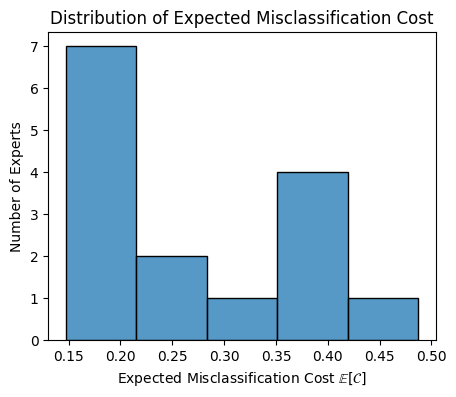

In [5]:
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = metrics['Cost'])
plt.xlabel(r"Expected Misclassification Cost $\mathbb{E}[\mathcal{C}]$")
plt.ylabel("Number of Experts")
plt.title(r"Distribution of Expected Misclassification Cost")

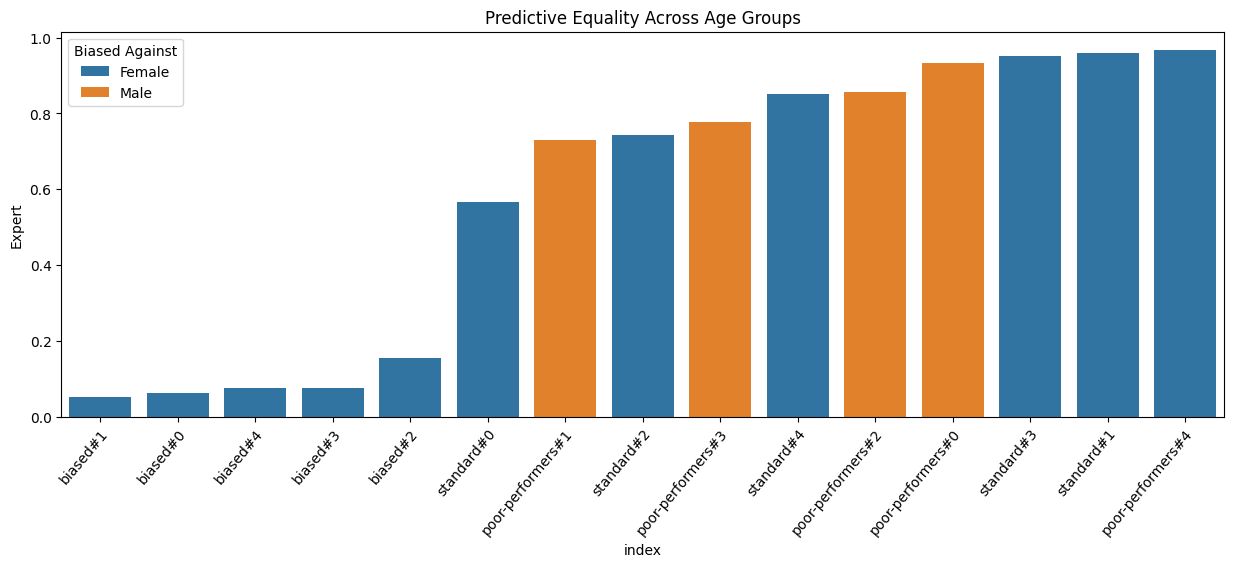

In [6]:
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = metrics.reset_index().sort_values('Predictive Equality'),x = 'index', y = 'Predictive Equality', hue = 'Biased Against', dodge = False)
plt.ylabel('Expert')
plt.title('Predictive Equality Across Age Groups')
plt.xticks(rotation = 50, rotation_mode = 'anchor', ha = 'right')
plt.show()

In [7]:
weights = pd.read_parquet('synthetic_experts/expert_predictions.parquet')

In [8]:
prop = pd.read_parquet(f'./synthetic_experts/expert_parameters.parquet')
p_error = pd.read_parquet(f'./synthetic_experts/prob_of_error.parquet').loc[data.index]
preds = pd.read_parquet(f'./synthetic_experts/expert_predictions.parquet').loc[data.index]
p = pd.DataFrame()

def invert_labels_with_probabilities(labels_arr, p_arr, seed):
    rng = np.random.default_rng(seed=seed)
    mask = rng.binomial(n=1, p=p_arr).astype(bool)

    new_labels = labels_arr.copy()
    new_labels[mask] = np.abs(new_labels[mask] - 1)  # inverts labels

    return new_labels
for expert in preds.columns:
    p[expert] = p_error.loc[data.index,'p_fp_' + expert] + p_error.loc[data.index,'p_fn_' + expert]

d = dict()
for expert in preds.columns:
    temp = []
    for i in range(10):
        temp.append(invert_labels_with_probabilities(
                    labels_arr=data[LABEL_COL],
                    p_arr=p[expert],
                    seed= i))
    d[expert] = temp

k = dict()
count = 0
for expert in preds.columns:
    temp = []
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            elif i>j:
                continue

            temp.append(cohen_kappa_score(d[expert][i],d[expert][j]))
            count+=1
    
    k[expert] = temp

Text(0.5, 1.0, 'Distribution of Intra-Labeler Agreement')

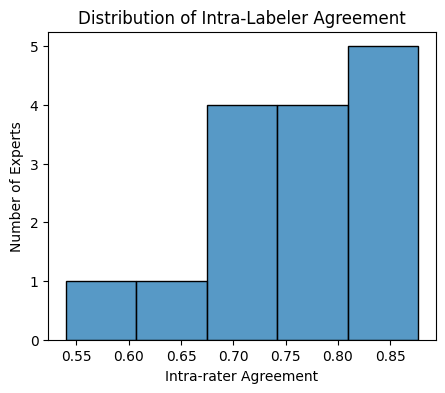

In [9]:
df = pd.DataFrame(k)
ck = df.melt().copy()
ck['alpha'] = ck.apply(lambda x: prop.loc[x['variable'],'alpha'], axis = 1)
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = ck.groupby('variable').mean()['value'])
plt.xlabel("Intra-rater Agreement")
plt.ylabel("Number of Experts")
plt.title("Distribution of Intra-Labeler Agreement")

Text(0.5, 1.0, 'Impact of $\\alpha$ on Intra-Labeler Agreement')

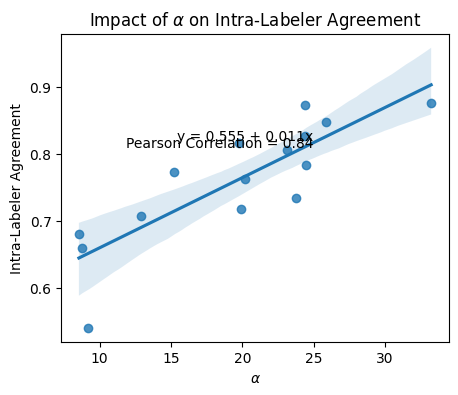

In [10]:
f, ax = plt.subplots(figsize=(5, 4))
p = sns.regplot(data = ck.groupby('variable').mean(), x = 'alpha', y = 'value')
#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#add regression equation to plot
plt.text(25, 0.82, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x', horizontalalignment = 'right')
plt.text(25, 0.81, 'Pearson Correlation = ' 
         + str(round(np.corrcoef(ck.groupby('variable').mean()['value'], ck.groupby('variable').mean()['alpha'])[0][1],3)),
         horizontalalignment = 'right')

plt.xlabel(r"$\alpha$")
plt.ylabel("Intra-Labeler Agreement")
plt.title(r"Impact of $\alpha$ on Intra-Labeler Agreement")

In [11]:
CK = pd.DataFrame(index = preds.columns, columns = preds.columns)

for expert1 in CK.columns:
    for expert2 in CK.columns:
        if expert1==expert2:
            CK.loc[expert1,expert2] = 1
            continue
        if not np.isnan(CK.loc[expert1,expert2]):
            continue
        CK.loc[expert1,expert2] = cohen_kappa_score(preds[expert1],preds[expert2])
        CK.loc[expert2,expert1] = CK.loc[expert1,expert2]

temp = []
for expert1 in CK.columns:
    for expert2 in CK.columns:
        if expert1==expert2:
            break
        else:
            temp.append(CK.loc[expert1,expert2])

print(f'Minimum: {np.min(temp)}, Maximum: {np.max(temp)}, Mean: {np.mean(temp)}')

Minimum: -0.21990293571795183, Maximum: 0.6556757434286772, Mean: 0.20678866878598468


Text(0.5, 1.0, "Distribution of Cohen's $\\kappa$ for Expert Pairs")

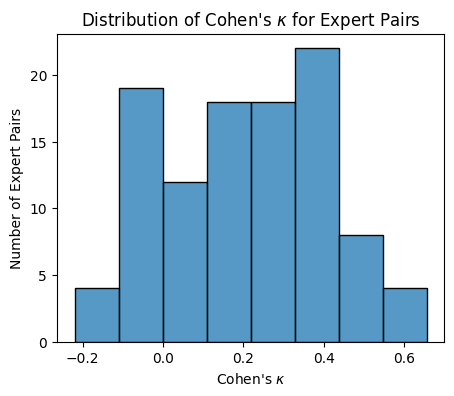

In [12]:
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = temp)
plt.xlabel(r"Cohen's $\kappa$")
plt.ylabel("Number of Expert Pairs")
plt.title(r"Distribution of Cohen's $\kappa$ for Expert Pairs")

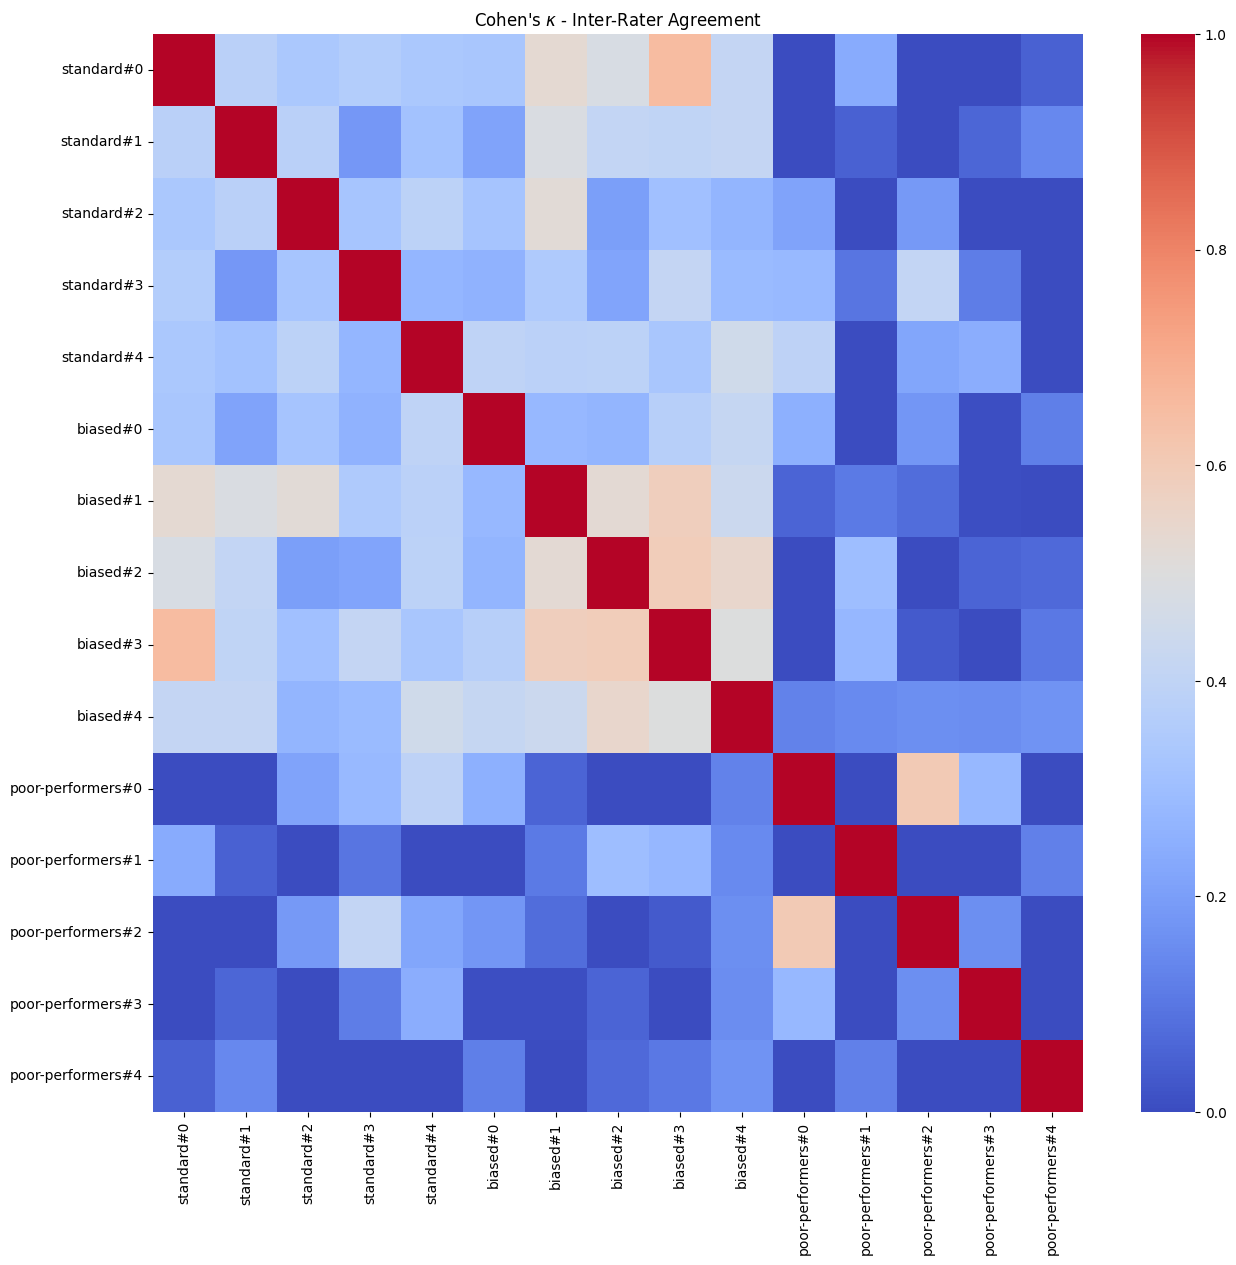

In [13]:
f, ax = plt.subplots(figsize=(15, 14))
sns.heatmap(CK.astype(float), robust=True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title(r"Cohen's $\kappa$ - Inter-Rater Agreement")
plt.show()

In [14]:
PA = pd.DataFrame(index = preds.columns, columns = preds.columns)
for expert1 in PA.columns:
    for expert2 in PA.columns:
        if expert1==expert2:
            PA.loc[expert1,expert2] = 1
            continue
        if not np.isnan(PA.loc[expert1,expert2]):
            continue
        PA.loc[expert1,expert2] = (preds[expert1] == preds[expert2]).astype(int).mean()
        PA.loc[expert2,expert1] = PA.loc[expert1,expert2]

temp = []
for expert1 in PA.columns:
    for expert2 in PA.columns:
        if expert1==expert2:
            break
        else:
            temp.append(PA.loc[expert1,expert2])

print(f'Minimum: {np.min(temp)}, Maximum: {np.max(temp)}, Mean: {np.mean(temp)}')

Minimum: 0.3826, Maximum: 0.8321, Mean: 0.6039580952380952


Text(0.5, 1.0, 'Distribution of Proportion of Agreement for Expert Pairs')

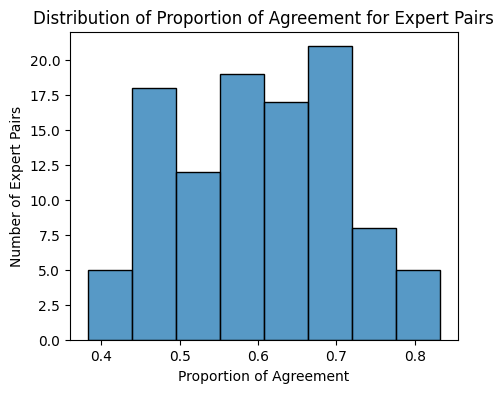

In [15]:
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = temp)
plt.xlabel(r"Proportion of Agreement")
plt.ylabel("Number of Expert Pairs")
plt.title(r"Distribution of Proportion of Agreement for Expert Pairs")

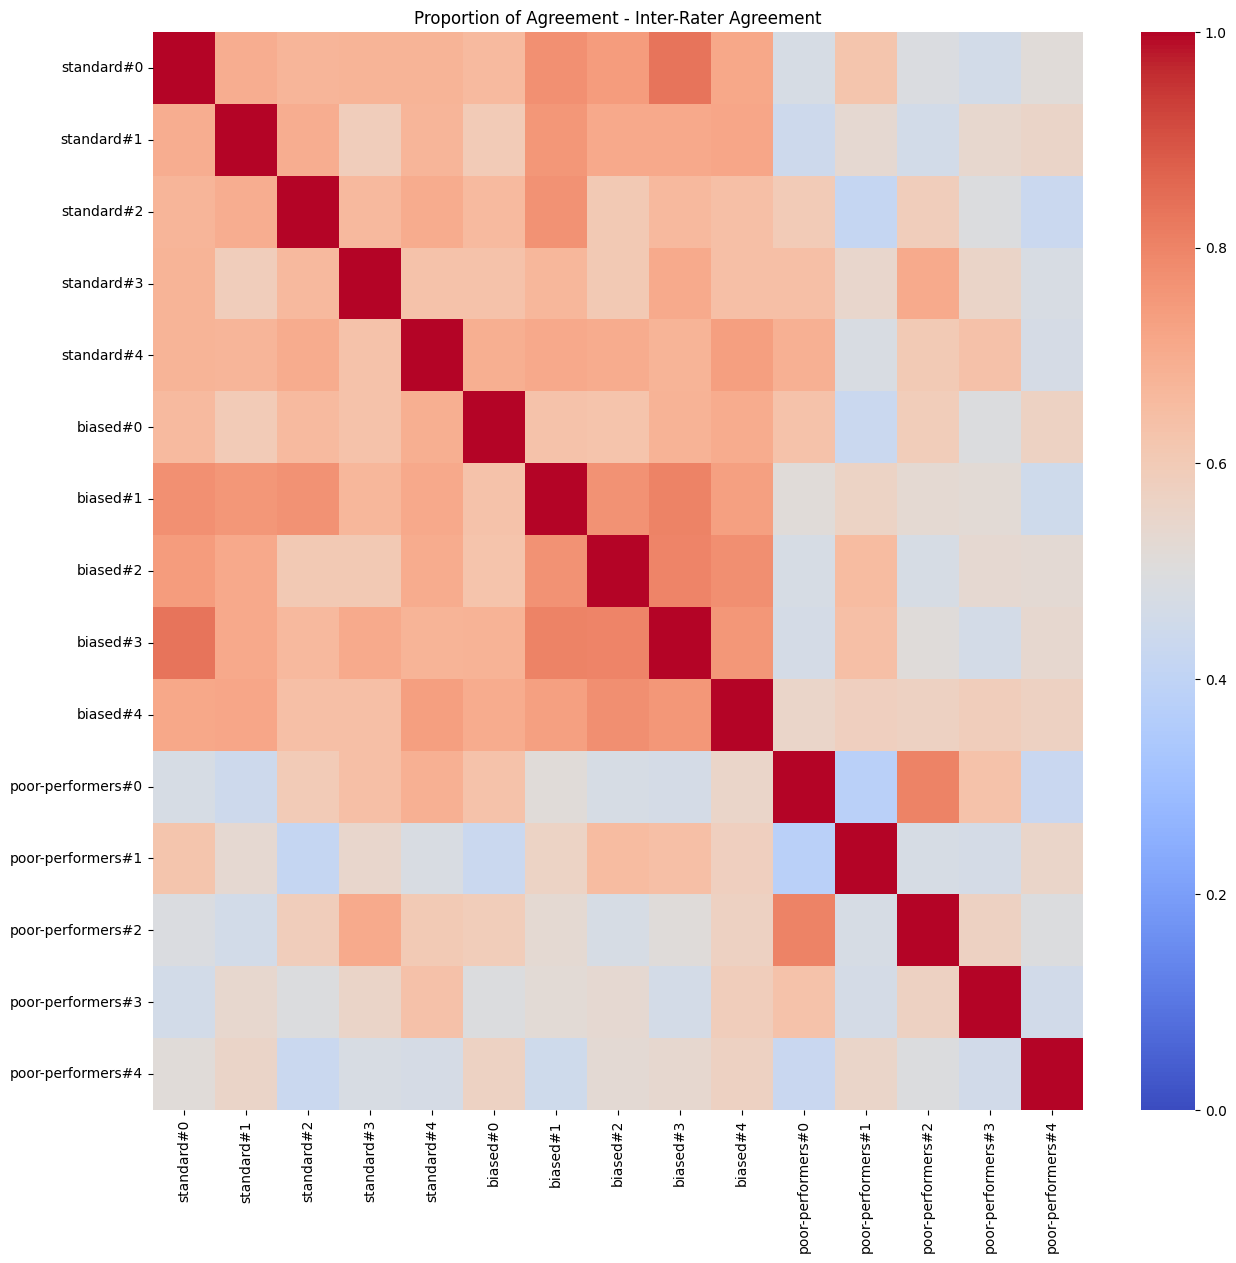

In [16]:
f, ax = plt.subplots(figsize=(15, 14))
sns.heatmap(PA.astype(float), robust=True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title(r"Proportion of Agreement - Inter-Rater Agreement")
plt.show()